In [1]:
NAME1 = "Caroline Andersson" 
NAME2 = "Adam Burman"
GROUP = "84"

In [2]:
### Check Python version
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','9'), "You are not running Python 3.9. Make sure to run Python through the course Conda environment."

### 1.1 Imports

In [136]:


path = r"C:\Users\carol\Deep Machine Learning\project\Dataset"

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import CenterCrop
from pathlib import Path
import torchvision.transforms

from torch import nn
from torch import optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
#import colorspacious as cs


import kornia # https://kornia.readthedocs.io/en/latest/color.html
#Lab color is computed using the D65 illuminant and Observer 2. (deafult in kornia)


from torchvision.transforms import Compose

In [137]:
# 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)

### 1.2 Load Data

Make a dataloader class

### 1.2.1 Load GTA Data and Return L, ab // or [1, s, s], [2, s, s]

In [138]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTALabData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        #label = Image.open(label_path)
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab
        
        L = img[0]#kornia.color.rgb_to_grayscale(img1/255)#img[0]
        a = img[1]
        b = img[2]

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform
            
            
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        #L = torch.cat((L.unsqueeze(0), L.unsqueeze(0), L.unsqueeze(0)), dim=0).squeeze()

        return (L-50)/50, ab/128
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths

In [139]:

transform = Compose([ToTensor()])

example_dataset = GTALabData(path, transform)
print(len(example_dataset)) #1
L, ab = example_dataset[2]
#print(img)
print(L.dtype)
print(L.shape)
print(ab.shape)
print(np.max(L.numpy()))

2500
torch.float32
torch.Size([1, 1052, 1914])
torch.Size([2, 1052, 1914])
1.0


### 1.2.1 Load GTA Data and Return L, (L, segmented image) // or [1, s, s], [2, s, s]

In [156]:

# GTASemanticData
# Note: there are 19 semantic classes
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
import glob
import os

class GTASegData(Dataset):
    

    def __init__(self, root, transform = None):
            """Constructor
        
        Args:
            root (Path/str): Filepath to the data root
            transform (Compose): A composition of image transforms.
        """
            root = Path(root)
            if not (root.exists() and root.is_dir()):
                raise ValueError(f"Data root '{root}' is invalid")
            
            self.root = root
            self.transform = transform
            self.img_paths, self.label_paths = self._collect_samples()
            
       
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample Tensor
        """
        
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        # Load the image and label into memory
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        
        img1 = torchvision.transforms.functional.pil_to_tensor(img) # PIL --> Tensor
        img = kornia.color.rgb_to_lab(img1/255) # RGB --> Lab
        
        L = img[0]
        a = img[1]
        b = img[2]

        # Perform transforms, if any.
        if self.transform is not None:
            L = self.transform(L.numpy()) # transform L
            label = self.transform(label) # transform
            a = self.transform(a.numpy()) # transform
            b = self.transform(b.numpy()) # transform

        #n_digits = 2
        #label = torch.round(label * 10**n_digits) / (10**n_digits) #round to 3 decimals
            
            
        
        
        ab = torch.cat((a.unsqueeze(0), b.unsqueeze(0)), dim=0).squeeze()
        out = torch.cat((L.unsqueeze(0)/100, label.unsqueeze(0)), dim=0).squeeze()

        return L/100, out # normalize L between [0, 1] to fit in cross entropy loss
    
    def __len__(self):
        """Get the number of samples in the dataset"""
        return len(self.img_paths)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        """Collect all paths and labels

        Helper method for the constructor
        """
        
        
        # Get image and label paths
        img_dir = self.root / "01_images" / "images"
        label_dir = self.root / "01_labels" / "labels"
        
        # check if there are images in the directory
        #self._check_images_in_directory(img_dir)
        #self._check_images_in_directory(label_dir)

        img_paths = list(img_dir.glob("*.png"))
        label_paths = list(label_dir.glob("*.png"))

        if len(img_paths) != len(label_paths):
            raise ValueError("Number of images and labels must be the same")
            
        return img_paths, label_paths


torch.Size([1, 512, 512])
torch.Size([2, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

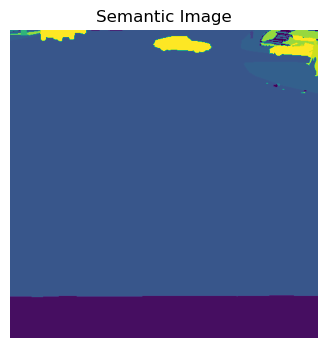

In [159]:
crop_size = (512, 512)
transform =  Compose([ToTensor(), CenterCrop(crop_size), Resize(crop_size, interpolation=Image.NEAREST)])

example_dataset1 = GTASegData(path, transform)
L1, s = example_dataset1[1]

print(L1.shape)
print(s.shape)
plt.figure(figsize=(8, 4))
plt.imshow(s[1].numpy().squeeze())
plt.title('Semantic Image')
plt.axis('off')

### 1.3 Augument

In [131]:
# Dataset 
mean = 52.37087932
std = 24.64118381
img_size = 128#224
#gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True), Normalize(mean, std, inplace=False)]) 
gta_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_dataset = GTALabData(path, gta_transform)

### 1.4 Chop up into train, val and test

In [95]:
from torch.utils.data import random_split

# Calculate mean std
#temp_dataset = GTALabData(path, ToTensor())

#test_img,_ = gta_dataset[0]
#print(test_img)
'''
number_of_samples = len(temp_dataset)
dataset_mean = []
dataset_std = []
for image,_ in temp_dataset:
    imgArray = np.array(image)
    #print(imgArray)
    dataset_mean.append(np.mean(imgArray))
    dataset_std.append(np.std(imgArray))

print(np.min(dataset_mean))
dataset_mean = np.mean(dataset_mean)
dataset_std = np.mean(dataset_std)
'''


test_img, ab = gta_dataset[0]
print(np.max(test_img.numpy()))
print(np.min(test_img.numpy()))


val_ratio = 0.15
test_ratio = 0.15

n_samples = len(gta_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

train_dataset, val_dataset, test_dataset = random_split(
    gta_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

0.9710671
-0.9831371


##  2. Create an Autoenconder for the Raw images
vgg16 can be used as the encoder by using transfer learning with the gtaV images. Then a decoder has to be constructed from scratch to generate a new image. The raw images are used in this section and later on another autoencoder will be trained with segmented images (our labels).

### 2.1 Create the Class

In [96]:
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Endocer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        #Decoder
        
        self.dconv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dbn1 = nn.BatchNorm2d(128)
        self.dconv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.dconv3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Encoder
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        
        # Decoder
        
        x = self.dconv1(x)
        x = self.relu(x)
        x = self.dbn1(x)
        x = self.dconv2(x)
        x = self.dbn2(x)
        x = self.relu(x)
        x = self.dconv3(x)
        
        
        x = self.tanh(x)
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return x

### 2.2 Train 

In [97]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss = train_epoch(model, optimizer, loss_fn, train_loader, device, print_every)
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {train_loss:.3f}, "
              f"Val. loss: {val_loss:.3f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, device, print_every):
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model(inputs)
        loss = loss_fn(z, labels)
        #print(np.min(z.detach().cpu().numpy())) #kan max bli 1????
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        if print_every is not None and batch_index % print_every == 0:
            model.train()
            print(f"Batch {batch_index}/{num_batches}: Train loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}")

    return model, sum(train_loss_batches) / len(train_loss_batches)

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model(inputs)
            batch_loss = loss_fn(z, labels)
            val_loss_cum += batch_loss.item()
    return val_loss_cum / len(val_loader)


In [98]:
# YOUR CODE HERE
batch_size = 32
base_model = AutoEncoder()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(base_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 1
print_every = 1


    
trained_single_model, train_losses, val_losses = training_loop(base_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 1/55: Train loss: 0.093
Batch 2/55: Train loss: 0.271
Batch 3/55: Train loss: 0.050
Batch 4/55: Train loss: 0.057
Batch 5/55: Train loss: 0.024
Batch 6/55: Train loss: 0.021
Batch 7/55: Train loss: 0.015
Batch 8/55: Train loss: 0.008
Batch 9/55: Train loss: 0.008
Batch 10/55: Train loss: 0.007
Batch 11/55: Train loss: 0.007
Batch 12/55: Train loss: 0.007
Batch 13/55: Train loss: 0.005
Batch 14/55: Train loss: 0.004
Batch 15/55: Train loss: 0.005
Batch 16/55: Train loss: 0.006
Batch 17/55: Train loss: 0.005
Batch 18/55: Train loss: 0.004
Batch 19/55: Train loss: 0.004
Batch 20/55: Train loss: 0.004
Batch 21/55: Train loss: 0.004
Batch 22/55: Train loss: 0.004
Batch 23/55: Train loss: 0.004
Batch 24/55: Train loss: 0.003
Batch 25/55: Train loss: 0.004
Batch 26/55: Train loss: 0.004
Batch 27/55: Train loss: 0.004
Batch 28/55: Train loss: 0.003
Batch 29/55: Train loss: 0.004
Batch 30/55: Train loss: 0.003
Batch 31/55: Train loss: 0.003
Batch 32/55: Train loss: 0.003

### 2.3 Evaluate Performance

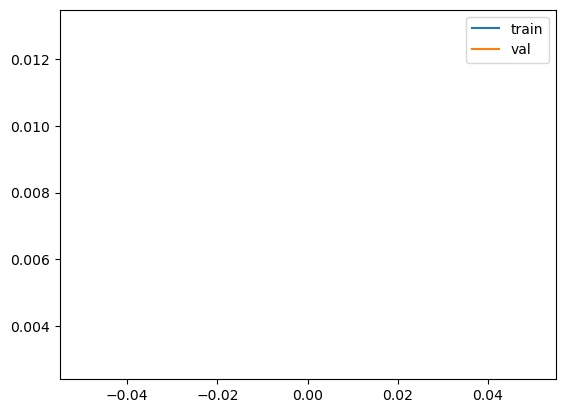

In [99]:
plt.figure()
plt.plot(range(0,len(train_losses)), train_losses)
plt.plot(range(0,len(val_losses)), val_losses)
plt.legend(['train', 'val'])
plt.show()


14.816179


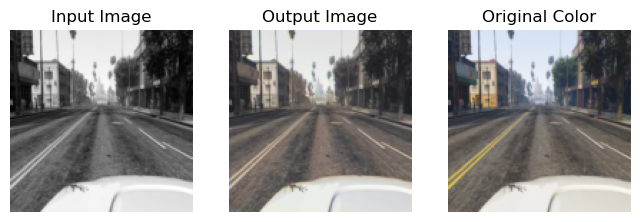

18.471846


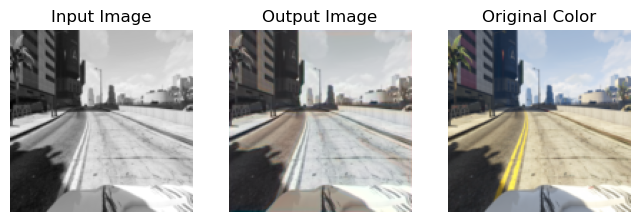

12.522967


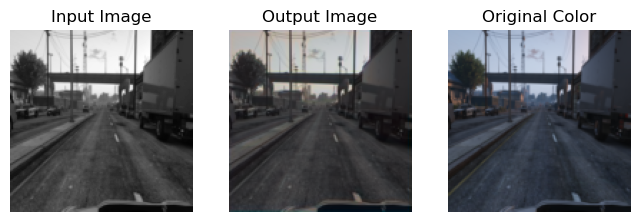

13.473209


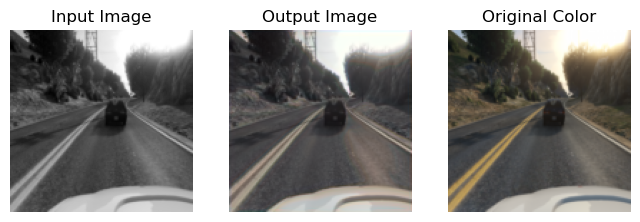

12.454517


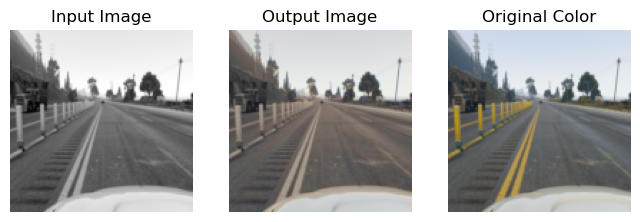

17.90205


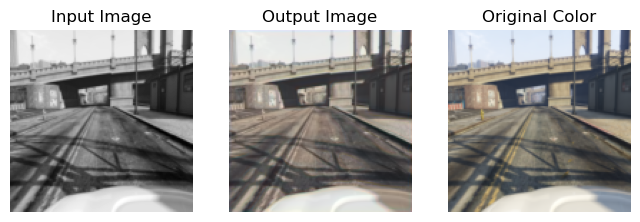

16.896002


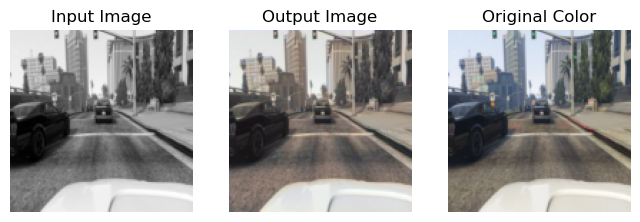

16.360409


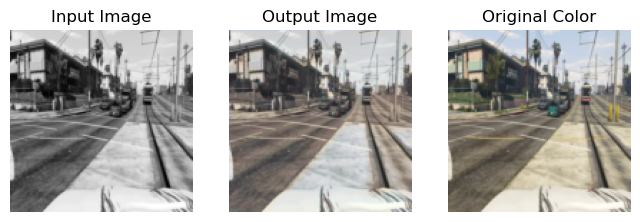

15.962252


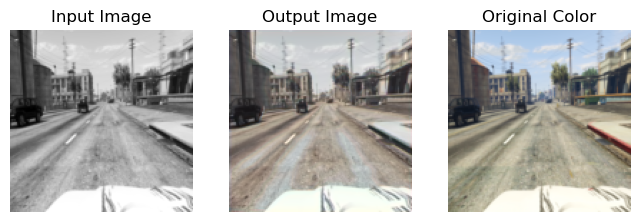

In [100]:

trained_single_model.eval()
test_image = train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_single_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)


        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

### 2.4 Save Model

In [101]:
torch.save({'model_state_dict': trained_single_model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, "./trained_single_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
saved_seg_model = AutoEncoder() # fill-in the arguments if needed
checkpoint = torch.load("trained_single_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])

Validation accuracies: [0.0028983303151714304]


## 3. Create a Network for Semantic Segmentation

In [160]:
import torch.nn.functional as F

class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Endocer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        
        #Decoder
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.tc1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.tc2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.tc3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        # Encoder
        input_img = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        
        # Decoder
        
        x = self.tc1(x)
        x = self.relu(x)
        x = self.tc2(x)
        x = self.relu(x)
        x = self.tc3(x)
        #x = self.relu(x)
        
        
        #x = self.tanh(x) # for cross entropy loss x should be [0, 1] range, thats why the loss gets negative
        out = torch.cat((input_img, x), dim=1)
        
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return out

In [161]:
gta_seg_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_seg_dataset = GTASegData(path, gta_transform)
img, label = gta_seg_dataset[0]

val_ratio = 0.15
test_ratio = 0.7

n_samples = len(gta_seg_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

s_train_dataset, s_val_dataset, s_test_dataset = random_split(
    gta_seg_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

In [162]:
# YOUR CODE HERE
batch_size = 32


seg_color_model = SegModel()

train_loader = DataLoader(s_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(s_val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(seg_color_model.parameters(), lr =0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 1
print_every = 1


#test_image = train_dataset[0][0]
#print(test_image.shape)

    
trained_seg_model, train_seg_losses, val_seg_losses = training_loop(seg_color_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
Batch 1/12: Train loss: 0.256
Batch 2/12: Train loss: 0.224
Batch 3/12: Train loss: 0.157
Batch 4/12: Train loss: 0.178
Batch 5/12: Train loss: 0.150
Batch 6/12: Train loss: 0.169
Batch 7/12: Train loss: 0.165
Batch 8/12: Train loss: 0.153
Batch 9/12: Train loss: 0.164
Batch 10/12: Train loss: 0.160
Batch 11/12: Train loss: 0.147
Batch 12/12: Train loss: 0.152
Epoch 1/1: Train loss: 0.173, Val. loss: 0.157


## 3.2 Evaluate results

127.99999
16383.999


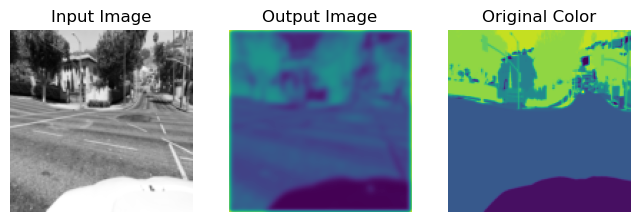

127.28549
16292.543


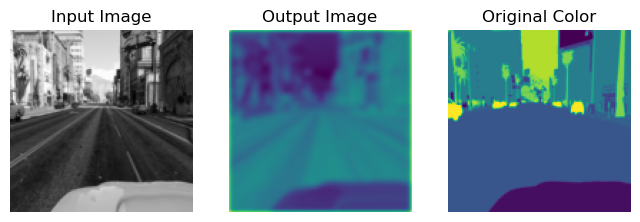

127.90512
16371.855


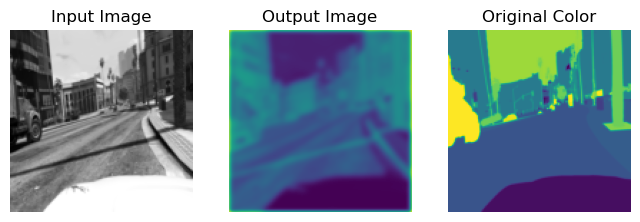

123.08169
15754.456


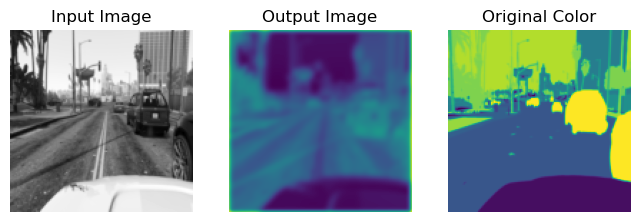

127.99997
16383.996


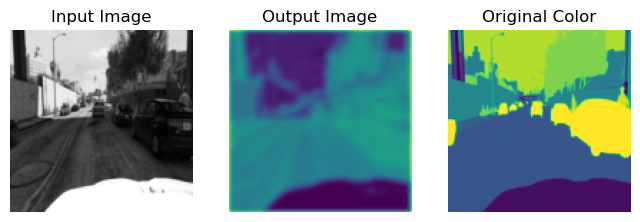

128.00005
16384.006


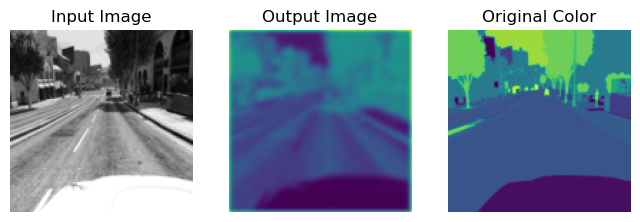

112.51349
14401.727


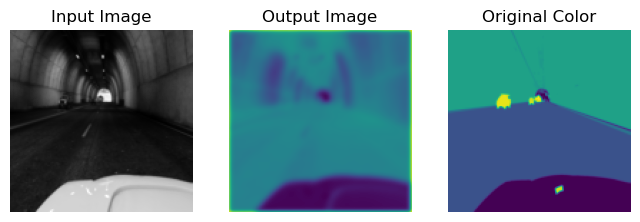

128.0
16384.0


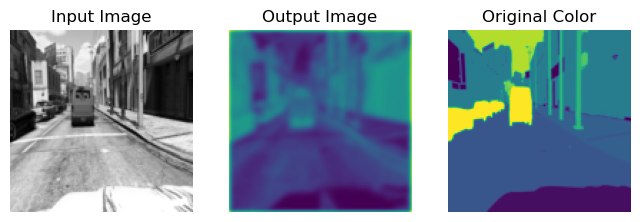

120.108536
15373.893


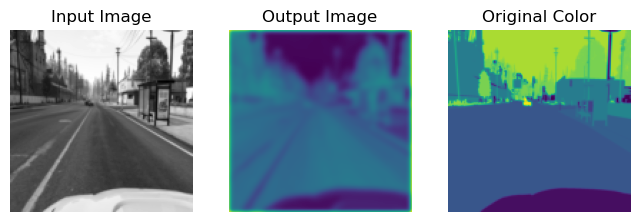

In [163]:
trained_seg_model.eval()
test_image = s_train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(s_test_dataset, batch_size=batch_size, shuffle=True)

counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_seg_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        print(np.max(input_labels.numpy()*128))
        

        # Network computed image
        segmented_image = output_img
        #color_img = torch.cat((input_img[0].unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        #color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        #color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        #input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        #original_color_image = torch.cat((input_img[0].unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        #original_color_image = kornia.color.lab_to_rgb(original_color_image)
        original_segmented_img = input_labels[1]

        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(output_img[1])
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        #plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.imshow(original_segmented_img.numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

## 3.3 Save model

In [24]:

torch.save({'model_state_dict': trained_seg_model.state_dict(),
            'train_losses': train_seg_losses,
            'val_losses': val_seg_losses,
            }, "./trained_seg_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint['val_losses'])

Validation accuracies: [-0.2333836667239666]


## 4. Create an Autoencoder that uses the Network  in 3.

Combine Semantic segmentation with a new autoencoder to colorize images.

### 4.1 Create Combined Model 

In [25]:
import torch.nn.functional as F

class CombinedAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        
        
        # Endocer
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        
        #Decoder
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.tc1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.tc2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.tc3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)  # Output has 2 channels (ab color channels)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        
    def forward(self, x):

        x = self.model(x)
        # Encoder
        
        x = self.conv1(x)
        #x, indices = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        
        # Decoder
        
        x = self.tc1(x)
        x = self.relu(x)
        
        x = self.tc2(x)
        x = self.relu(x)
        #x = self.unpool(x, indices)
        x = self.tc3(x)
        
        
        x = self.tanh(x)
        
        # Perform upsampling to the desired size [1052, 1914]
        #x = F.interpolate(x, size=(1052, 1914), mode='bilinear', align_corners=False)
       
        
        return x

In [71]:
AutoEncoder2 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=3, padding=1),
    nn.ReLU(),  
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 2, kernel_size=3, padding=1),
    nn.Tanh()  
)




class CombinedModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(CombinedModel, self).__init__()
        self.modelA = modelA # semantic segmentation
        self.modelB = modelB # colorization
        
        
    def forward(self, x):
        x = self.modelA(x)
        x = self.modelB(x)
        
        
        return x


saved_seg_model = SegModel() # fill-in the arguments if needed
checkpoint = torch.load("trained_seg_model.ckpt")
saved_seg_model.load_state_dict(checkpoint['model_state_dict'])
combined = CombinedModel(saved_seg_model, AutoEncoder2)


### 4.2 Freeze Layers

In [72]:
for param in trained_seg_model.parameters():
    param.requires_grad = False

In [73]:
gta__combined_transform = Compose([ToTensor(), Resize((img_size, img_size), antialias=True)])
gta_combined_dataset = GTALabData(path, gta_transform)

val_ratio = 0.15
test_ratio = 0.7

n_samples = len(gta_combined_dataset)
n_val_samples = int(n_samples * val_ratio)
n_test_samples = int(n_samples * test_ratio)
n_train_samples = n_samples - n_val_samples - n_test_samples

combined_train_dataset, combined_val_dataset, combined_test_dataset = random_split(
    gta_combined_dataset, [n_train_samples, n_val_samples, n_test_samples]
)

In [74]:
# YOUR CODE HERE
batch_size = 32


train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(combined_val_dataset, batch_size=batch_size, shuffle=True)



optimizer = optim.Adam(combined.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
num_epochs = 1
print_every = 1


    
trained_combined_model, train_losses, val_losses = training_loop(combined, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

Starting training
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 1/12: Train loss: 0.004
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 2/12: Train loss: 0.024
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 3/12: Train loss: 0.005
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 4/12: Train loss: 0.014
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 5/12: Train loss: 0.004
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 6/12: Train loss: 0.004
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 7/12: Train loss: 0.004
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 8/12: Train loss: 0.003
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 9/12: Train loss: 0.004
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 10/12: Train loss: 0.003
torch.Size([32, 1, 128, 128])
torch.Size([32, 2, 128, 128])
Batch 11/12: Train lo

### 4.2 Evaluate Results

torch.Size([10, 1, 128, 128])
torch.Size([10, 2, 128, 128])
4.549438
tensor([[[ -0.2312,  -0.2871,  -0.3397,  ...,  -0.8728,  -0.9183,  -1.1695],
         [ -0.4925,  -0.4692,  -0.4673,  ...,  -0.9966,  -1.2442,  -1.4333],
         [ -0.2346,  -0.2926,  -0.4091,  ...,  -1.3124,  -1.3434,  -1.2076],
         ...,
         [ -1.9804,  -0.6159,   0.1069,  ...,  -1.0850,  -1.0407,  -0.9980],
         [ -1.0618,  -0.2717,  -0.2462,  ...,  -1.1021,  -1.0952,  -1.1091],
         [ -0.0932,  -0.7838,  -1.0558,  ...,  -1.1277,  -1.0774,  -1.1210]],

        [[-10.8022, -10.9050, -10.9423,  ...,  -6.2508,  -7.1015,  -8.6080],
         [-11.6709, -11.1888, -10.9481,  ...,  -7.6390,  -8.6997,  -9.2067],
         [-10.0637, -10.1545, -10.2820,  ...,  -8.9531,  -9.0000,  -8.5668],
         ...,
         [ -4.7568,  -5.6443,  -6.1513,  ...,  -5.6174,  -5.5973,  -5.6112],
         [ -4.6486,  -5.0726,  -5.2094,  ...,  -5.8422,  -5.8173,  -5.7800],
         [ -5.4614,  -4.5259,  -4.3793,  ...,  -5.9529

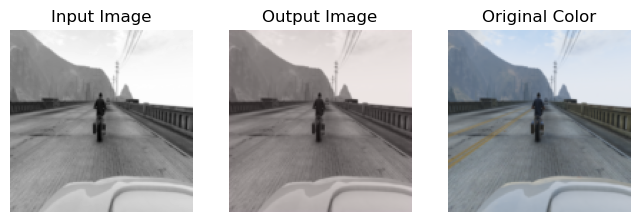

4.6272416
tensor([[[-1.8206e+00, -1.7083e+00, -1.9151e+00,  ...,  3.2895e-01,
          -8.5554e-02, -1.9101e-01],
         [-2.2804e+00, -2.0753e+00, -1.9791e+00,  ...,  4.9543e-01,
          -6.0272e-03, -1.1344e-01],
         [-1.9510e+00, -1.9324e+00, -1.8046e+00,  ...,  4.5589e-01,
          -2.0115e-02, -7.8603e-02],
         ...,
         [ 1.0458e+00,  1.1684e+00,  5.6991e-01,  ..., -7.6710e-01,
          -7.9817e-01, -5.4151e-01],
         [ 1.2662e+00,  9.1563e-01,  2.6166e-02,  ..., -2.5805e-01,
          -2.0951e-01, -6.7776e-04],
         [ 9.7182e-01,  2.3574e-01, -9.8795e-03,  ...,  1.9492e-01,
           5.7293e-01,  1.2999e+00]],

        [[-9.7539e+00, -9.0987e+00, -8.8712e+00,  ..., -1.0276e+00,
          -1.1072e+00, -7.4579e-01],
         [-9.2845e+00, -9.1455e+00, -8.9430e+00,  ..., -1.0869e+00,
          -1.2361e+00, -8.6309e-01],
         [-8.9272e+00, -8.9408e+00, -8.5389e+00,  ..., -1.0352e+00,
          -1.1925e+00, -8.1434e-01],
         ...,
         [-6.37

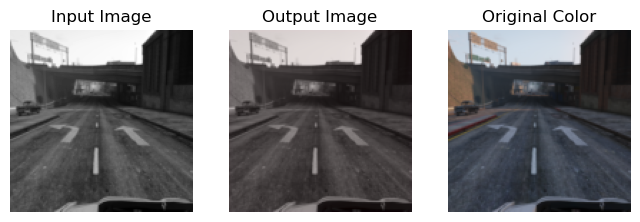

4.5675797
tensor([[[ -0.2196,  -0.3091,  -0.4098,  ...,  -0.5982,  -0.5790,  -0.5538],
         [ -0.5448,  -0.4156,  -0.2985,  ...,  -0.5081,  -0.6499,  -0.3521],
         [ -0.4364,  -0.5415,  -0.5771,  ...,  -0.2746,  -0.3026,  -0.0815],
         ...,
         [  0.9182,   0.4095,  -0.0890,  ...,   0.2180,   0.1687,   0.1120],
         [  0.5656,  -0.6915,  -0.8650,  ...,   0.2093,   0.3084,   0.1990],
         [ -0.8983,  -1.1931,  -0.5255,  ...,   0.2017,   0.2857,   0.1612]],

        [[-11.9303, -11.9900, -12.0295,  ..., -12.1729, -12.0096, -12.3363],
         [-11.5434, -11.7611, -11.8774,  ..., -12.3974, -12.1179, -12.6609],
         [-10.8565, -11.4432, -11.5598,  ..., -10.9416, -10.7776, -11.5173],
         ...,
         [  9.3316,   9.2899,   8.2137,  ...,   1.4855,   2.0467,   2.9124],
         [  8.8609,   8.7922,   8.5858,  ...,   1.1446,   1.2570,   1.4033],
         [  9.0688,   8.7924,   8.3020,  ...,   0.8771,   0.9100,   0.9626]]])
torch.Size([128, 128]) shape
torch

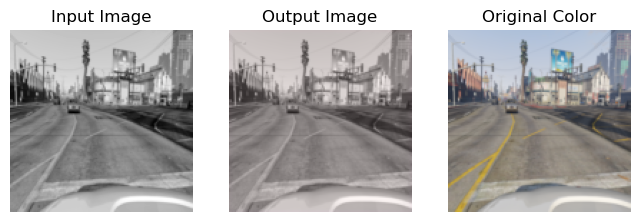

torch.Size([10, 1, 128, 128])
torch.Size([10, 2, 128, 128])
4.540147
tensor([[[-1.2292, -1.6533, -1.8051,  ..., -1.2243, -1.2739, -1.4530],
         [-1.2158, -1.4245, -1.7171,  ..., -1.4766, -1.4940, -1.3955],
         [-1.5419, -1.6174, -1.7580,  ..., -1.3263, -1.1710, -1.0671],
         ...,
         [ 1.3696,  0.9736,  1.9727,  ..., -1.2101, -1.0799, -0.9552],
         [ 1.4653,  1.6569,  2.2615,  ..., -1.5597, -1.1965, -0.9848],
         [ 2.1298,  2.1592,  2.7761,  ..., -1.7568, -1.4096, -1.0984]],

        [[ 2.3259,  2.0586,  2.1438,  ..., -2.0326, -1.9258, -1.7847],
         [ 2.1428,  2.0303,  2.2667,  ..., -1.7494, -1.6462, -1.5812],
         [ 2.2194,  2.1857,  2.3123,  ..., -1.5554, -1.5009, -1.4522],
         ...,
         [11.8779, 12.5155, 12.6575,  ..., 11.3138, 11.1263, 10.9998],
         [12.7456, 12.8198, 13.3866,  ..., 11.7748, 11.1719, 10.8618],
         [12.8494, 13.4231, 13.5793,  ..., 12.1206, 11.4410, 10.9417]]])
torch.Size([128, 128]) shape
torch.Size([3, 128

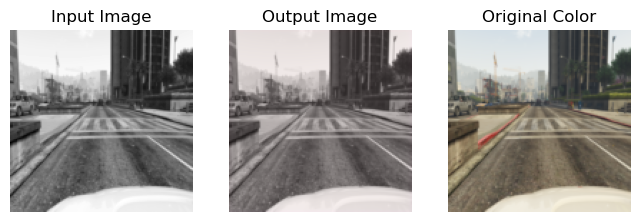

4.596853
tensor([[[-21.2431,  -3.7419,  -6.1154,  ...,  -1.0445,  -0.4935,  -0.5588],
         [-23.3832, -20.1027,  -2.6324,  ...,  -0.8600,  -0.7046,  -0.5925],
         [ -3.4147, -16.6706, -13.9571,  ...,  -0.8366,  -0.6355,  -0.5670],
         ...,
         [  0.8213,   0.7203,  -0.3111,  ...,  -0.3943,  -0.4079,  -0.4118],
         [  1.1381,   1.0415,   1.0658,  ...,  -0.3828,  -0.4325,  -0.3758],
         [  0.7829,   0.5797,   0.2369,  ...,  -0.3531,  -0.3791,  -0.4265]],

        [[ 10.6285,  18.3704,  18.0991,  ...,   0.9901,   0.5702,   0.7571],
         [  9.7032,  11.0013,  17.5507,  ...,   0.9662,   1.0433,   0.8123],
         [ 17.4521,  13.3211,  13.8894,  ...,   0.8685,   0.6824,   0.6053],
         ...,
         [  4.5092,   4.0104,   4.3410,  ...,   7.5275,   7.6185,   7.6050],
         [  3.6071,   3.7162,   5.0354,  ...,   7.3140,   7.3952,   7.3573],
         [  4.1030,   4.2740,   6.7705,  ...,   7.1089,   7.2109,   7.2408]]])
torch.Size([128, 128]) shape
torch.

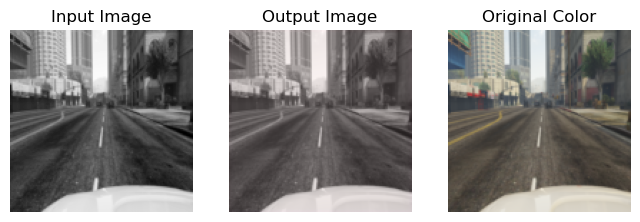

4.594424
tensor([[[-2.1630, -0.8846, -0.8215,  ..., -0.1669, -0.1479, -0.1436],
         [-1.9637, -0.8491, -0.7251,  ..., -0.1413, -0.1633, -0.3260],
         [-1.8223, -1.1836, -1.6992,  ..., -0.0990, -0.0382, -0.2753],
         ...,
         [-0.2673, -0.6145, -0.3671,  ..., -0.1910, -0.3991, -0.6374],
         [-0.3373, -0.5211, -0.7976,  ..., -0.3012, -0.4119, -0.4155],
         [-0.8646, -0.9418, -0.8806,  ..., -0.0364, -0.2610, -0.5647]],

        [[10.0606,  6.3803,  4.6441,  ...,  9.0114,  7.1636,  5.1441],
         [ 8.0198,  6.0283,  4.4618,  ..., 12.2468,  8.5410,  5.0691],
         [ 7.0430,  6.3796,  4.9830,  ..., 12.4466,  8.4291,  4.9745],
         ...,
         [-1.0659, -0.5740, -0.7006,  ..., -2.5255, -2.4428, -1.3187],
         [-0.6155, -0.4233,  0.2793,  ..., -1.8436, -2.5403, -2.6158],
         [-0.6055, -0.3510,  0.0407,  ..., -1.9380, -1.7779, -1.9947]]])
torch.Size([128, 128]) shape
torch.Size([3, 128, 128]) o


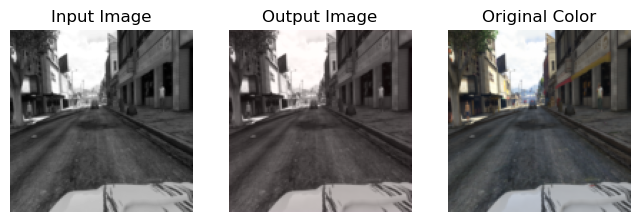

torch.Size([10, 1, 128, 128])
torch.Size([10, 2, 128, 128])
4.604411
tensor([[[ 1.3480e+00,  7.9718e-01,  1.6805e+00,  ...,  8.7488e+00,
           8.6726e+00,  8.4885e+00],
         [-1.0151e-01,  2.8548e-01, -1.1851e-01,  ...,  8.6252e+00,
           8.4152e+00,  8.2853e+00],
         [ 1.0551e+00, -6.5368e-05,  1.9218e-01,  ...,  8.1842e+00,
           7.8555e+00,  7.7953e+00],
         ...,
         [-9.7983e-01, -1.2574e+00, -1.4808e+00,  ..., -9.1721e-01,
          -1.2335e+00, -1.2731e+00],
         [-1.6261e+00, -1.8417e+00, -1.8140e+00,  ..., -4.9258e-01,
          -8.3333e-01, -1.0702e+00],
         [-2.2692e+00, -1.8624e+00, -1.8689e+00,  ..., -3.6127e-01,
          -4.7949e-01, -6.8274e-01]],

        [[ 1.4189e+01,  1.4160e+01,  1.3364e+01,  ...,  7.6769e+00,
           7.4481e+00,  7.2867e+00],
         [ 1.0572e+01,  1.1045e+01,  1.1118e+01,  ...,  7.0125e+00,
           6.6885e+00,  6.6103e+00],
         [ 4.2050e+00,  6.3472e+00,  5.3867e+00,  ...,  6.1167e+00,
       

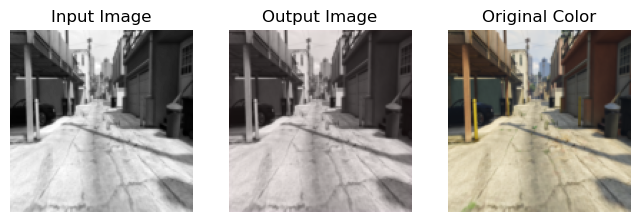

4.558901
tensor([[[ -6.8886, -11.2708,  -8.7275,  ...,  -0.8766,  -0.8963,  -0.8966],
         [ -2.7409,  -6.3052,  -7.2189,  ...,  -0.7740,  -0.7627,  -0.7925],
         [  1.3631,  -2.6198,  -4.3060,  ...,  -0.5643,  -0.5677,  -0.5988],
         ...,
         [  2.9916,   2.5362,   2.3347,  ...,  -1.4658,  -1.4652,  -1.4304],
         [  2.9800,   2.1997,   1.9148,  ...,  -1.3606,  -1.3940,  -1.3949],
         [  2.5742,   1.8349,   0.8791,  ...,  -1.3455,  -1.3455,  -1.3495]],

        [[ 18.3090,  31.2561,  17.1421,  ...,  -4.7839,  -4.4550,  -4.3797],
         [ 10.5817,  17.3769,  17.0952,  ...,  -4.8703,  -4.4385,  -4.5407],
         [ 10.7955,   8.8911,  13.1067,  ...,  -4.6582,  -4.4940,  -4.6951],
         ...,
         [ 17.1586,  16.9242,  17.0314,  ...,   9.5885,   9.6631,   9.6396],
         [ 17.2626,  17.1978,  17.8610,  ...,   9.2688,   9.3689,   9.3716],
         [ 17.2686,  17.4700,  17.5830,  ...,   9.2234,   9.2234,   9.2355]]])
torch.Size([128, 128]) shape
torch.

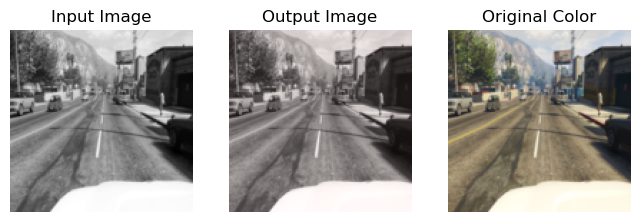

4.583032
tensor([[[-0.9991, -0.7506, -0.6165,  ..., -3.7049, -2.0990,  5.1666],
         [-1.0958, -0.9165, -0.7385,  ..., -1.7401,  5.8656, 16.1491],
         [-1.2121, -1.0094, -0.8578,  ...,  9.1548, 14.5089, 16.7513],
         ...,
         [ 0.5540,  1.2216,  0.0708,  ..., -1.0213, -1.0458, -1.1735],
         [-1.3199, -0.3198,  0.7604,  ..., -1.1851, -1.1953, -1.2026],
         [-0.7796,  0.2071,  0.3125,  ..., -0.9352, -0.9541, -1.0081]],

        [[-6.3120, -6.7283, -7.0768,  ...,  3.3065, -0.4793,  6.3521],
         [-6.2701, -6.5277, -6.8878,  ...,  0.0475,  6.1809, 22.7417],
         [-6.1957, -6.4935, -6.8749,  ...,  9.9095, 18.2853, 24.1044],
         ...,
         [16.5520, 16.6540, 15.1138,  ...,  7.8262,  7.8557,  7.9969],
         [16.8610, 15.8459, 12.5605,  ...,  7.7259,  7.7584,  7.8040],
         [15.9166, 13.7933, 12.2496,  ...,  7.7015,  7.7426,  7.7300]]])
torch.Size([128, 128]) shape
torch.Size([3, 128, 128]) o


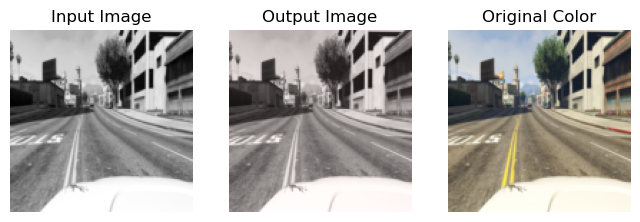

In [76]:
trained_combined_model.eval()
test_image = train_dataset[0][0]
#print(test_image.shape)
batch_size = 10
# Iterate through the test data
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=True)


counter = 0
for batch in test_loader:
    inputs, labels = batch  # You can ignore the labels
    if counter == 3:
        break
    else:
        counter += 1

    # Perform inference
    with torch.no_grad():
        outputs = trained_combined_model(inputs.to(device))

    # View the input and output images
    for i in range(3):
        input_img = inputs[i].squeeze().cpu()*50 + 50 # rescale [-1,1] --> [0, 100]
        input_labels = labels[i].squeeze().cpu()*128 # rescale [-1,1] --> [-128, 128]
        output_img = outputs[i].cpu()*128 # rescale [-1,1] --> [-128, 128]
        print(np.max(output_img.numpy()))
        print(input_labels)
        print(input_img.shape, 'shape')

        # Network computed image
        color_img = torch.cat((input_img.unsqueeze(0) ,output_img[0].unsqueeze(0), output_img[1].unsqueeze(0)), dim=0).cpu() # restore Lab image
        color_img = kornia.color.lab_to_rgb(color_img) #Lab --> RGB
        color_img = color_img.permute(1, 2, 0).cpu().numpy()
        

        # Original Image
        #input_labels = F.interpolate(input_labels.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False).squeeze(1).cpu()
        original_color_image = torch.cat((input_img.unsqueeze(0) ,input_labels[0].unsqueeze(0), input_labels[1].unsqueeze(0)), dim=0)
        original_color_image = kornia.color.lab_to_rgb(original_color_image)
        print(original_color_image.shape, 'o')

        # Display the input and output images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_img)
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_color_image.permute(1, 2, 0).numpy())
        plt.title('Original Color')
        plt.axis('off')

        plt.show()

#output = trained_gta_model(test_image)
#test_dataloader = DataLoader()

## 5. Compare the Two Autoencoders